## Setup and Import Libraries

In [1]:
import os
import bs4
from typing_extensions import List, TypedDict
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.agents import tool
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-5")

## Creating Vector Store

In [5]:
def create_vector_store(web_paths, chunk_size=1000, chunk_overlap=200):

    loader = WebBaseLoader(
        web_paths=(web_paths,),
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("post-content", "post-title", "post-header")
            )
        ),
    )

    documents = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

    chunks = text_splitter.split_documents(documents=documents)

    vector_store = FAISS.from_documents(
        documents=chunks,
        embedding=embeddings
    )

    print(f"Vector store created with {vector_store.index.ntotal} vectors")

    return vector_store

In [6]:
web_paths = "https://lilianweng.github.io/posts/2023-06-23-agent/"

vector_store = create_vector_store(web_paths=web_paths, chunk_size=1000, chunk_overlap=200)
vector_store

Vector store created with 63 vectors


In [7]:
vector_store.similarity_search("What is Task Decomposition")

[Document(id='d51fa750-0b2a-44eb-b5cc-b81852841bc0', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-f

## Creating Tool

In [8]:
@tool()
def retrieve(query:str):
    """
    Retrieve the information related to the query
    """
    retrieved_documents = vector_store.similarity_search(query, k=2)
    serialized_document = "\n\n".join(
        (f"Source: {retrieved_document.metadata}\nContent: {retrieved_document.page_content}")
        for retrieved_document in retrieved_documents
    )
    return serialized_document, retrieved_documents

In [9]:
retrieve

StructuredTool(name='retrieve', description='Retrieve the information related to the query', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x000001F0240CD800>)

## Creating Agent

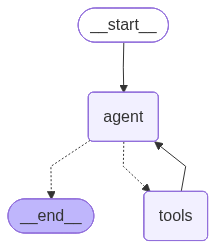

In [10]:
memory = MemorySaver()

agent_executor = create_react_agent(
    model=llm,
    tools=[retrieve],
    checkpointer=memory
)

agent_executor

In [11]:
config = {"configurable": {"thread_id": "thread2"}}

In [12]:
input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

In [13]:
for event in agent_executor.stream(
    input={"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_lZQOYMoeZiKInmowkCYdiEjy)
 Call ID: call_lZQOYMoeZiKInmowkCYdiEjy
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decomp